In [1]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="0EKSrlH9OVngYfgQCrauwqLEt",
                        project_name="mri-interpretation", workspace="polina")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/polina/mri-interpretation/800481c5f5334e83a0932f2cad3212da



In [2]:
# !pip install torchio

In [3]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
# from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
import torchio
import nibabel as nib
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
import random
from sklearn.metrics import roc_auc_score, precision_score, recall_score
%matplotlib inline

In [4]:
import nilearn
from nilearn import plotting

In [5]:
from data import HCP_MRI_sp_aug
# from data import HCP_MRI_crop

In [6]:
 torch.cuda.is_available()

True

In [7]:
if torch.cuda.is_available():
  device = torch.device("cuda:5")
else:
  device = torch.device("cpu")

In [8]:
! nvidia-smi

Tue Mar 30 10:45:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   30C    P0    38W / 250W |   2849MiB / 16280MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   28C    P0    40W / 250W |  13785MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Data

In [9]:
data_dir = pathlib.Path('/data/adni')

In [10]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [11]:
# PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
PATH_TO_MRI = '/home/crop_data_resize'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

In [12]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

HCP absmax before normalization: 435.0126647949219
Train Dataset size: 889
Test Dataset size: 223
Labels distribution: (array([0, 1]), array([482, 407]))

Train example:


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


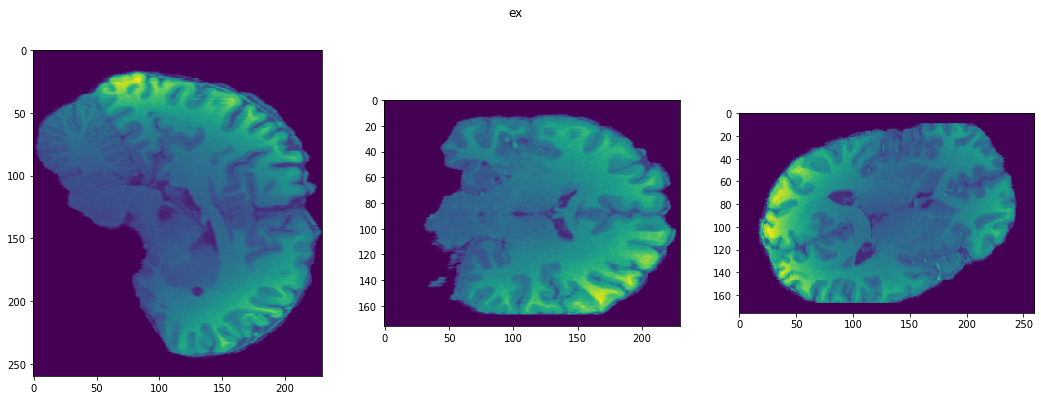

Val example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


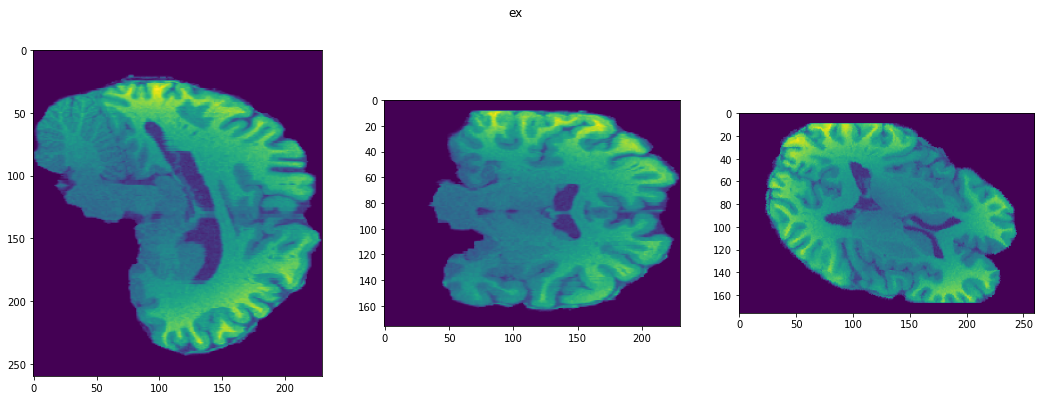

In [13]:
X_train, X_test = train_test_split(pd.read_csv(behavioral_path), test_size=0.2, random_state=42) 
train_hcp_dataset = HCP_MRI_sp_aug(
    paths= PATH_TO_MRI,
    target_path= X_train,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55,( 15, 15, 0, 19, 34, 51)
    img_shape=(176, 260, 230) #176, 260, 230, (226, 301, 235), 256, 320, 320
)
val_hcp_dataset = HCP_MRI_sp_aug(
    paths= PATH_TO_MRI,
    target_path= X_test,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55
    img_shape=(176, 260, 230) #176, 260, 230, 226, 301, 235), 256, 320, 320
)

hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
train_transform_man = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 35),
    RandomAffine(degrees = 0, scale=(0.9, 0.9)) #0.8,1.2
#     ToTensor(),
])

train_transform_woman = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 25),
    RandomAffine(degrees = 0, scale=(1.1, 1.1)) #0.8,1.2
#     ToTensor(),
])
val_transform_man = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 35),
    RandomAffine(degrees = 0, scale=(0.9, 0.9)) #0.8,1.2
#     ToTensor(),
])

val_transform_woman = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 25),
    RandomAffine(degrees = 0, scale=(1.1, 1.1)) #0.8,1.2
#     ToTensor(),
])
# val_transform = Compose([
# #     BrightnessContrast(),
# #     GaussNoise(),
# #     Rotate(),
#     ToTensor(),
# ])
# train_transform = torchio.transforms.Compose([
# #     BrightnessContrast(),
# #     GaussNoise(),
#     torchio.transforms.RandomAffine(scales=(0.8, 1.2), degrees = 10),
# #     ToTensor(),
# ])

train_hcp_dataset.transform_man = train_transform_man
train_hcp_dataset.transform_women = train_transform_woman
val_hcp_dataset.transform_man = val_transform_man
val_hcp_dataset.transform_women = val_transform_woman
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Train Dataset size: {}".format(len(train_hcp_dataset)))
print("Test Dataset size: {}".format(len(val_hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(train_hcp_dataset.labels, return_counts=True)))

print("Train example:")
img, target = train_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)
print("Val example:")
img, target = val_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [14]:
train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

In [15]:
type(train_loader.dataset.mri_paths)

list

# Model structure

In [15]:
# timing
from tqdm import tqdm

def get_metric(net, data_loader):
    net.eval()
    correct = 0
    true = []
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device, dtype=torch.float)
        target = target.to(device)
    
        out = net(data)
        loss += criterion(out, target).item()*len(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        del data, target, out 
    accuracy = 100. * correct / len(data_loader.dataset)
    return loss / len(data_loader.dataset), accuracy.item()


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False, experiment= False):
    best_val_loss = 100000 #100_000
    best_val_acc = 0
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    loss, acc = get_loss(net, train_loader)
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    loss, acc = get_loss(net, val_loader)
    val_loss_list.append(loss)
    val_acc_list.append(acc)
    del loss, acc
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device, dtype=torch.float), y.to(device)
            optimizer.zero_grad()
#             print(type(X))
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(X)
            pred = out.data.max(1)[1] # get the index of the max log-probability
            train_correct += pred.eq(y.data).cpu().sum()
            del X, y, out, loss #freeing gpu space
        accuracy = 100. * train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss/len(train_loader.dataset))
        train_acc_list.append(accuracy.item())
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        loss, acc = get_loss(net, val_loader)
        val_loss_list.append(loss)
        val_acc_list.append(acc)
        
        if scheduler is not None:
            scheduler.step(val_acc_list[-1])

        if save and val_acc_list[-1] > best_val_acc:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_acc_model_' + model_name)    
            best_val_acc = val_acc_list[-1]
            
        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_val_loss_model_' + model_name)
            best_val_loss = val_loss_list[-1]
            
        if save and epoch%5==0:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + str(epoch) + '_epoch_model_' + model_name)
            
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f} Acc: Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1], train_acc_list[-1], val_acc_list[-1] ))
        if experiment:
                experiment.log_metric("train_loss", train_loss_list[-1])
                experiment.log_metric("validate_loss", val_loss_list[-1])
                experiment.log_metric("train_acc", train_acc_list[-1])
                experiment.log_metric("validate_acc", val_acc_list[-1])
                experiment.log_epoch_end(epoch)
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

In [15]:
torch.cuda.empty_cache()

In [16]:
CHECKPOINTS_DIR =  '/home/checkpoints_smart_aug/'

In [16]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [18]:
if torch.cuda.device_count() > 1:
      d_ids= [5,6]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

model.to(device)

Let's use [5, 6] GPUs!


DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [21]:
# criterion = nn.NLLLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #return ADAM?
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
criterion = nn.CrossEntropyLoss()


In [22]:
model_name = '_checkpoints_smart_aug'
experiment.set_name("3DCNN_checkpoints_smart_aug")

In [ ]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 60

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

In [ ]:
!cd /home/checkpoints_torchion_reshape && ls

In [ ]:
model.load_state_dict(torch.load('/home/checkpoints_torchion_reshape/best_acc_model__checkpoints_torchio_reshape'))
model.eval()

In [ ]:
get_metric(model, val_loader)

In [ ]:
get_metric(model, train_loader)

In [ ]:
!jupyter notebook list

In [17]:
CHECKPOINTS_DIR =  '/home/checkpoints_smart_aug/'

In [19]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
for X_train, X_test in skf.split(pd.read_csv(behavioral_path),pd.read_csv(behavioral_path).Gender):
    print('Doing {} split'.format(j))
    j += 1
    train_hcp_dataset = HCP_MRI_sp_aug(
    paths= PATH_TO_MRI,
    target_path= pd.read_csv(behavioral_path).iloc[X_train],
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55,( 15, 15, 0, 19, 34, 51)
    img_shape=(176, 260, 230) #176, 260, 230, (226, 301, 235), 256, 320, 320
    )
    val_hcp_dataset = HCP_MRI_sp_aug(
        paths= PATH_TO_MRI,
        target_path=  pd.read_csv(behavioral_path).iloc[X_test],
        load_online=True,
        hcp_type = hcp_type,
        coord_min=(40, 40, 30, 30, 45, 45), #40,25,55
        img_shape=(176, 260, 230) #176, 260, 230, 226, 301, 235), 256, 320, 320
    )

    hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
    train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    train_transform_man = Compose([
        ToTensor(),
    #     BrightnessContrast(),
    #     GaussNoise(),
        RandomRotation(degrees = 25),
        RandomAffine(degrees = 0, scale=(0.9, 0.9)) #0.8,1.2
    #     ToTensor(),
    ])

    train_transform_woman = Compose([
        ToTensor(),
    #     BrightnessContrast(),
    #     GaussNoise(),
        RandomRotation(degrees = 25),
        RandomAffine(degrees = 0, scale=(1.1, 1.1)) #0.8,1.2
    #     ToTensor(),
    ])

    val_transform = Compose([
    #     BrightnessContrast(),
    #     GaussNoise(),
    #     Rotate(),
        ToTensor(),
    ])

    train_hcp_dataset.transform_man = train_transform_man
    train_hcp_dataset.transform_woman = train_transform_woman
    val_hcp_dataset.transform_man = train_transform_man
    val_hcp_dataset.transform_woman = train_transform_woman
    train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
    val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)
#     model = mri_model.MriNet(C).to(device)
#     criterion = nn.NLLLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    c = 32
    model = MriNetGrad(c)
    if torch.cuda.device_count() > 1:
        d_ids= [5,6]
        print("Let's use", d_ids, "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)
        model.to(device)
    model_name = 'smart_aug_cv_{}'.format(j)
    experiment.set_name("3DCNN_smart_aug_cv_{}".format(j))
    torch.save(train_loader.dataset.mri_paths, CHECKPOINTS_DIR + 'train_' +model_name)
    torch.save(val_loader.dataset.mri_paths, CHECKPOINTS_DIR + 'val_' +model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
    criterion = nn.CrossEntropyLoss()
    EPOCHS = 60

    train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 
#     _, _, _, _ = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, device, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list.append(get_accuracy(model, val_loader, device))
    print(cross_vall_acc_list[-1])
print('Mean cross-validation accuracy (5-folds):', np.mean(cross_vall_acc_list))
print('Std cross-validation accuracy (5-folds):', np.std(cross_vall_acc_list, ddof=1))

Doing 0 split
Let's use [5, 6] GPUs!


  0%|          | 0/223 [00:00<?, ?it/s]/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
100%|██████████| 112/112 [02:48<00:00,  1.51s/it]


Epoch 00/60 || Loss:  Train 0.7058 | Validation 0.7059


100%|██████████| 112/112 [02:45<00:00,  1.47s/it]
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 01/60 || Loss:  Train 0.0185 | Validation 0.0000 Acc: Train 99.2126 | Validation 100.0000


100%|██████████| 112/112 [02:47<00:00,  1.49s/it]


Epoch 02/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:44<00:00,  1.46s/it]


Epoch 03/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:43<00:00,  1.46s/it]


Epoch 04/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:46<00:00,  1.49s/it]


Epoch 05/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:50<00:00,  1.52s/it]


Epoch 06/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:44<00:00,  1.47s/it]


Epoch 07/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:46<00:00,  1.48s/it]


Epoch 08/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:58<00:00,  1.59s/it]


Epoch 09/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [03:17<00:00,  1.77s/it]


Epoch 10/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:46<00:00,  1.49s/it]


Epoch 11/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [03:08<00:00,  1.68s/it]


Epoch 12/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:36<00:00,  1.40s/it]


Epoch 13/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:52<00:00,  1.54s/it]


Epoch 14/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:51<00:00,  1.53s/it]


Epoch 15/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [03:07<00:00,  1.67s/it]


Epoch 16/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 17/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [03:02<00:00,  1.63s/it]


Epoch 18/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:41<00:00,  1.44s/it]


Epoch 19/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:42<00:00,  1.45s/it]


Epoch 20/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:43<00:00,  1.46s/it]


Epoch 21/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:48<00:00,  1.51s/it]


Epoch 22/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:25<00:00,  1.30s/it]


Epoch 23/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:22<00:00,  1.27s/it]


Epoch 24/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:25<00:00,  1.30s/it]


Epoch 25/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:17<00:00,  1.22s/it]


Epoch 26/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:19<00:00,  1.25s/it]


Epoch 27/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:17<00:00,  1.23s/it]


Epoch 28/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:18<00:00,  1.23s/it]


Epoch 29/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:21<00:00,  1.26s/it]


Epoch 30/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:19<00:00,  1.25s/it]


Epoch 31/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:42<00:00,  1.45s/it]


Epoch 32/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:20<00:00,  1.25s/it]


Epoch 33/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:54<00:00,  1.56s/it]


Epoch 34/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [03:17<00:00,  1.76s/it]


Epoch 35/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [03:07<00:00,  1.67s/it]


Epoch 36/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [03:03<00:00,  1.64s/it]


Epoch 37/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


 88%|████████▊ | 99/112 [02:06<00:16,  1.29s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 112/112 [02:21<00:00,  1.26s/it]


Epoch 46/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000


100%|██████████| 112/112 [02:22<00:00,  1.27s/it]


Epoch 47/60 || Loss:  Train 0.0000 | Validation 0.0000 Acc: Train 100.0000 | Validation 100.0000
